<a href="https://colab.research.google.com/github/jjungmini/pv-forecasting/blob/main/H2O/%EC%98%A8%EC%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h2o
!pip install mxnet
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.2-py2.py3-none-any.whl size=265363806 sha256=c2ed0c5f8fe3e9da6fa091f0bef41ec08b10ac42b9da0d36628f9e405efcba9b
  Stored in directory: /root/.cache/pip/wheels/e9/ea/ab/889709967692e30c57c46137edd2cae6b2768bb65ec7cb8aa5
Successfully built h2o
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:00


In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns

In [ ]:
# 데이터 로딩
df = pd.read_excel('pvdata.xlsx', sheet_name=1)

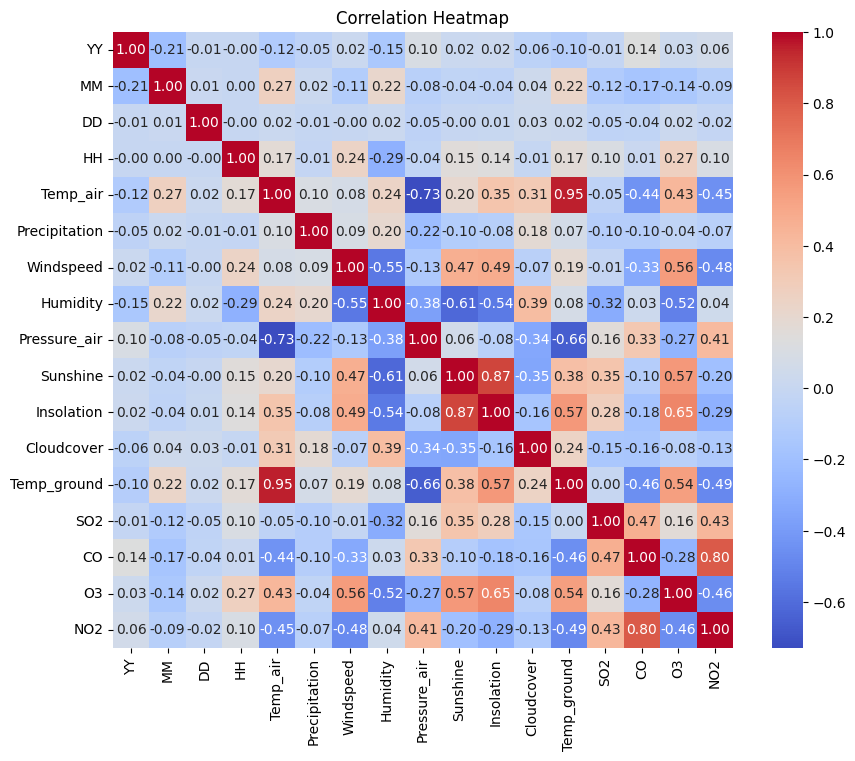

In [ ]:
# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['solarpower'] = target_scaler.fit_transform(df[['solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외

correlation_matrix = df.drop(columns=['Date', 'solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2023-04-01']
test = df[(df['Date'] >= '2023-04-01') & (df['Date'] < '2023-05-01')]

# AutoML 학습을 위한 데이터셋 설정

In [ ]:
# H2O 라이브러리 초기화
h2o.init()

# H2O 데이터프레임으로 변환
h2o_train = h2o.H2OFrame(train.drop('Date', axis=1))

# Date 열을 제외한 특성과 타겟 변수를 정의
x = h2o_train.columns
x.remove('solarpower')

y = 'solarpower'

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpx7ksv1mh
  JVM stdout: /tmp/tmpx7ksv1mh/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpx7ksv1mh/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,"14 days, 2 hours and 54 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_ywag6l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# AutoML 설정 및 모델 훈련 (모든 파라미터를 원하는 값으로 변경하여 설정)
aml = H2OAutoML(
     max_runtime_secs=3600,     # AutoML 실행에 허용할 최대 시간 (초)
    # max_models=20,             # 생성할 최대 모델 수
    stopping_metric='RMSE',    # 조기 종료를 위한 평가 지표
    stopping_tolerance=0.01,  # 조기 종료를 위한 허용 오차
    stopping_rounds=3,         # 조기 종료를 위한 반복 횟수
    nfolds=5,                  # 교차 검증(fold)의 개수
    seed=42,                   # 랜덤 시드
    # exclude_algos = ["StackedEnsemble"],

   #include_algos=['Deeplearning'], #'DRF', 'XGBoost'],  # 사용할 알고리즘들의 리스트
    keep_cross_validation_predictions=True,  # 교차 검증 예측 결과 보존 여부
    keep_cross_validation_models=False,      # 교차 검증 모델 보존 여부
    keep_cross_validation_fold_assignment=False,  # 교차 검증 폴드 할당 보존 여부
    sort_metric='RMSE',        # 성능 측정 기준
    export_checkpoints_dir=None  # 모델 체크포인트를 내보낼 디렉토리
)

aml.train(x=x, y=y, training_frame=h2o_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/64
# GBM base models (used / total),4/28
# XGBoost base models (used / total),4/29
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/4
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


# Automl 학습결과 확인

In [ ]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# 모든 모델의 성능 순위를 변수로 저장
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    exec(f"model_rank_{rank} = h2o.get_model('{model_id}')")

# 모든 모델의 성능 순위 출력
print("\n<< 모든 모델의 성능 순위 >>")
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    print(f"Model: {model_id}, Rank: {rank}")

model_id                                                      rmse          mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20231122_124509     0.0220071  0.000484314  0.0117651  0.0170667               0.000484314
StackedEnsemble_BestOfFamily_4_AutoML_1_20231122_124509  0.0224613  0.000504511  0.012266   0.0174222               0.000504511
StackedEnsemble_AllModels_1_AutoML_1_20231122_124509     0.0225949  0.000510531  0.0124284  0.0175362               0.000510531
StackedEnsemble_AllModels_2_AutoML_1_20231122_124509     0.0225966  0.000510606  0.0124297  0.0175375               0.000510606
StackedEnsemble_BestOfFamily_2_AutoML_1_20231122_124509  0.0230081  0.00052937   0.0127674  0.0178196               0.00052937
GBM_grid_1_AutoML_1_20231122_124509_model_10             0.0230291  0.00053034   0.0126058  0.017854                0.00053034
StackedEnsemble_BestOfFamily_1_AutoML_1_20231122_124509  0.0230491  0.00053126   0.0128791  0.0178694     

In [ ]:
# 순위별로 모델에 대한 세부 정보 출력
# n등의 모델을 출력하려면 : print(model_rank_n)
print(model_rank_1)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20231122_124509


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       8/64
# GBM base models (used / total)           4/28
# XGBoost base models (used / total)       4/29
# DRF base models (used / total)           0/2
# DeepLearning base models (used / total)  0/4
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00011290605182943046
RMSE: 0.01062572594364406
MAE: 0.006141023508245321
RMSLE: 0.0084

In [ ]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# Excel 파일 생성
writer = pd.ExcelWriter('train_result_온실.xlsx', engine='xlsxwriter')

# 모든 모델의 파라미터 정보를 저장하는 새로운 열을 추가합니다.
all_parameters = []
for index, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)
    model_params = model.params
    all_parameters.append(model_params)

leaderboard_df['Parameters'] = all_parameters

# DataFrame을 첫 번째 시트로 저장합니다.
leaderboard_df.to_excel(writer, sheet_name='Leaderboard', index=True)



# 엑셀 파일 저장
writer.save()

model_id                                                      rmse          mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_3_AutoML_1_20231122_124509     0.0220071  0.000484314  0.0117651  0.0170667               0.000484314
StackedEnsemble_BestOfFamily_4_AutoML_1_20231122_124509  0.0224613  0.000504511  0.012266   0.0174222               0.000504511
StackedEnsemble_AllModels_1_AutoML_1_20231122_124509     0.0225949  0.000510531  0.0124284  0.0175362               0.000510531
StackedEnsemble_AllModels_2_AutoML_1_20231122_124509     0.0225966  0.000510606  0.0124297  0.0175375               0.000510606
StackedEnsemble_BestOfFamily_2_AutoML_1_20231122_124509  0.0230081  0.00052937   0.0127674  0.0178196               0.00052937
GBM_grid_1_AutoML_1_20231122_124509_model_10             0.0230291  0.00053034   0.0126058  0.017854                0.00053034
StackedEnsemble_BestOfFamily_1_AutoML_1_20231122_124509  0.0230491  0.00053126   0.0128791  0.0178694     

<ipython-input-9-72826b138178>:27: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


# 모델 학습 결과 시각화 용

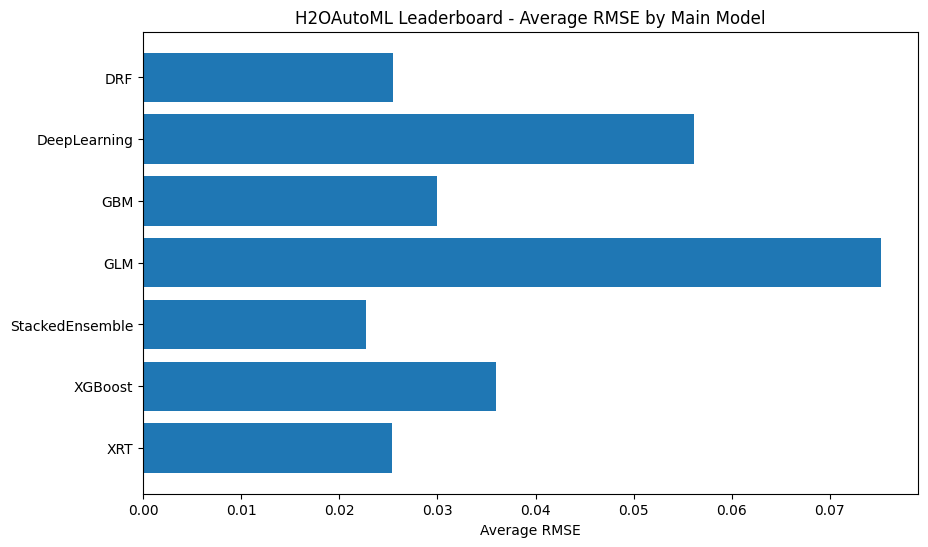

In [ ]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 평균값 계산
group_means = grouped_leaderboard['rmse'].mean()

# 그룹 평균값을 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(group_means.index, group_means.values)
plt.xlabel('Average RMSE')
plt.title('H2OAutoML Leaderboard - Average RMSE by Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()

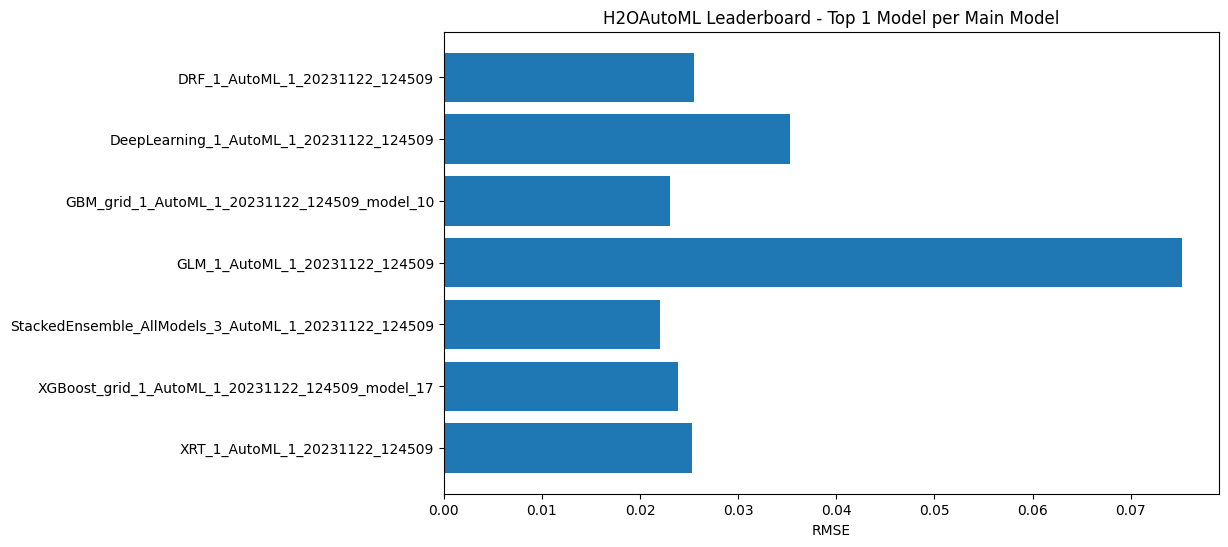

In [ ]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 1위 모델 선택 (가장 낮은 RMSE 값을 가진 모델)
top_1_models = grouped_leaderboard.apply(lambda group: group.nsmallest(1, 'rmse'))

# 메인 모델별 1위 모델의 RMSE를 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(top_1_models['model_id'], top_1_models['rmse'])
plt.xlabel('RMSE')
plt.title('H2OAutoML Leaderboard - Top 1 Model per Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()

# best 모델 출력하고, 예측을 위한 df 변환

In [ ]:
# 가장 성능이 좋은 모델 선택
best_model = aml.leader

# 선택된 특성 출력
print("Best model is: ", best_model)

Best model is:  Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_3_AutoML_1_20231122_124509


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       8/64
# GBM base models (used / total)           4/28
# XGBoost base models (used / total)       4/29
# DRF base models (used / total)           0/2
# DeepLearning base models (used / total)  0/4
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.00011290605182943046
RMSE: 0.01062572594364406
MAE: 0.0061410235082453

In [ ]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 테스트 데이터를 H2O 데이터프레임으로 변환
h2o_test = h2o.H2OFrame(test.drop('Date', axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# 원하는 rank의 모델 사용하여 test data 예측 수행

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 177.38360343625575
평균 절대 오차 (MAE): 7.4856910309026725
결정 계수 (R2): 0.9841757589333541
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 13.31854359291044


<ipython-input-13-b056e2400552>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


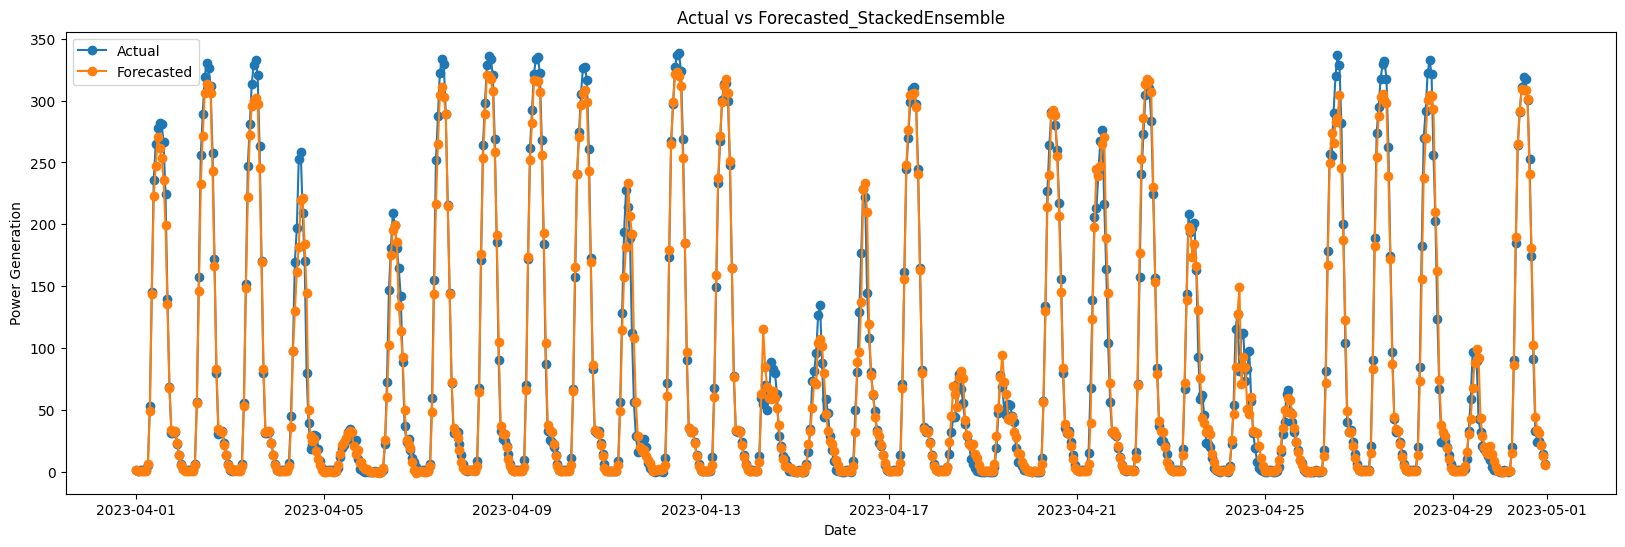

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 188.23926430647973
평균 절대 오차 (MAE): 7.816383928786036
결정 계수 (R2): 0.983207334618928
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 13.720031498013396


<ipython-input-13-b056e2400552>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


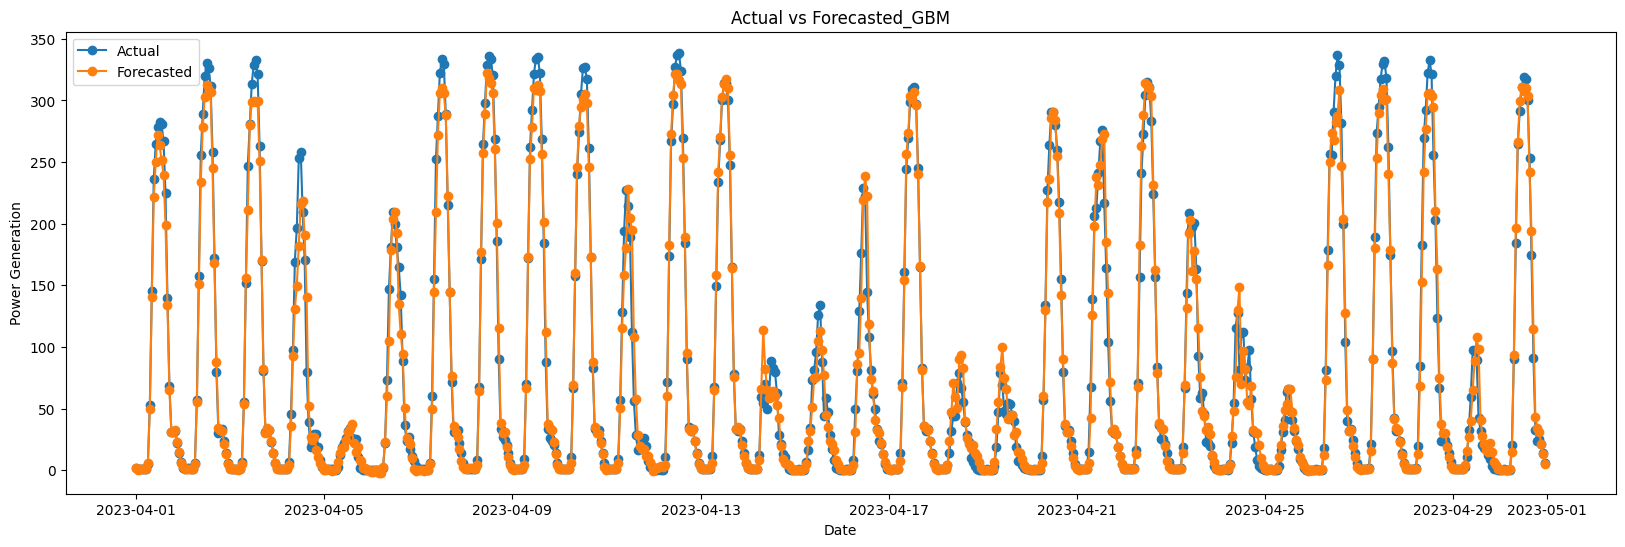

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 196.7565047052631
평균 절대 오차 (MAE): 7.85267757019117
결정 계수 (R2): 0.9824475188147499
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 14.02699200489054


<ipython-input-13-b056e2400552>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


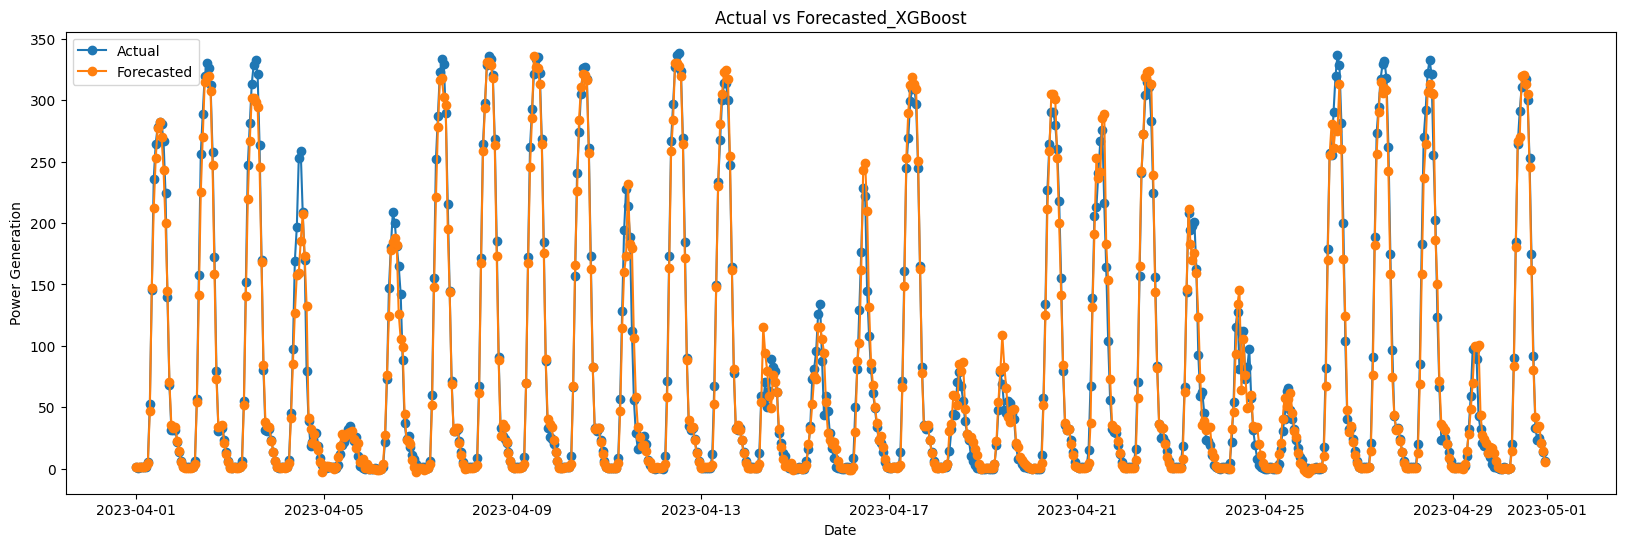

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 319.7476243592411
평균 절대 오차 (MAE): 10.469108792211184
결정 계수 (R2): 0.9714755851706087
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 17.881488314993277


<ipython-input-13-b056e2400552>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


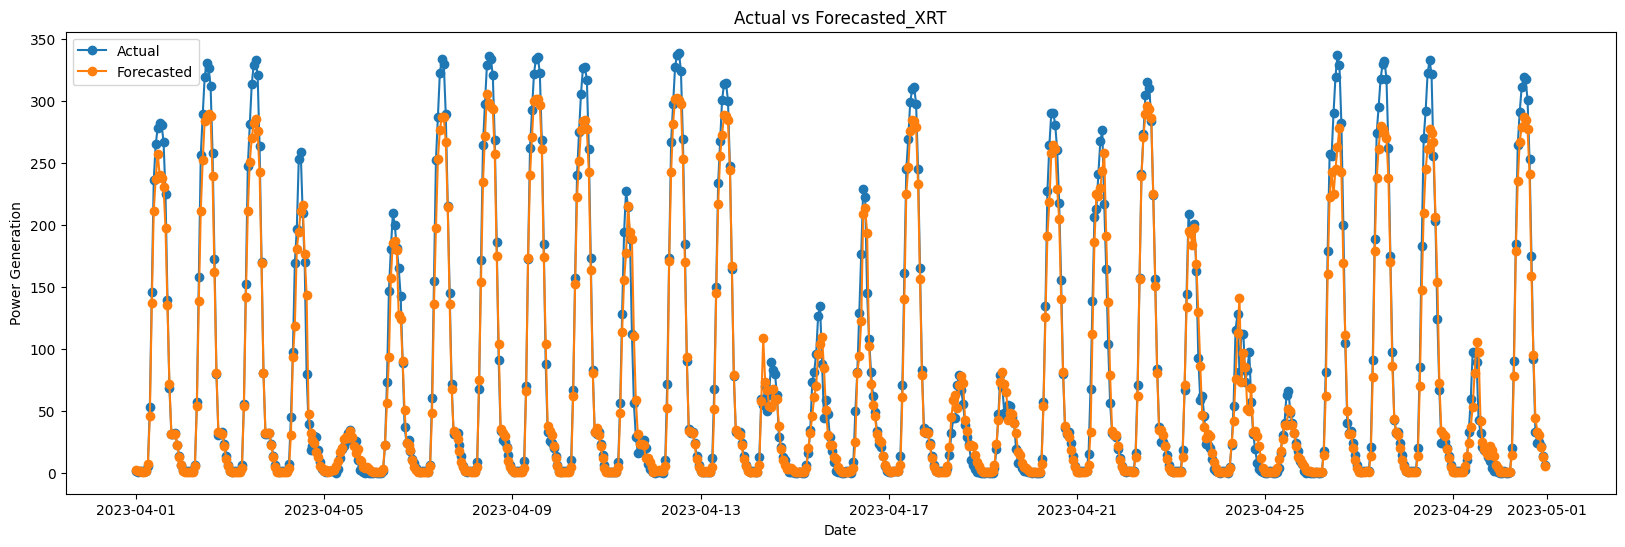

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 347.6327106609719
평균 절대 오차 (MAE): 10.969297817427487
결정 계수 (R2): 0.9689879802327522
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 18.644911119685496


<ipython-input-13-b056e2400552>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


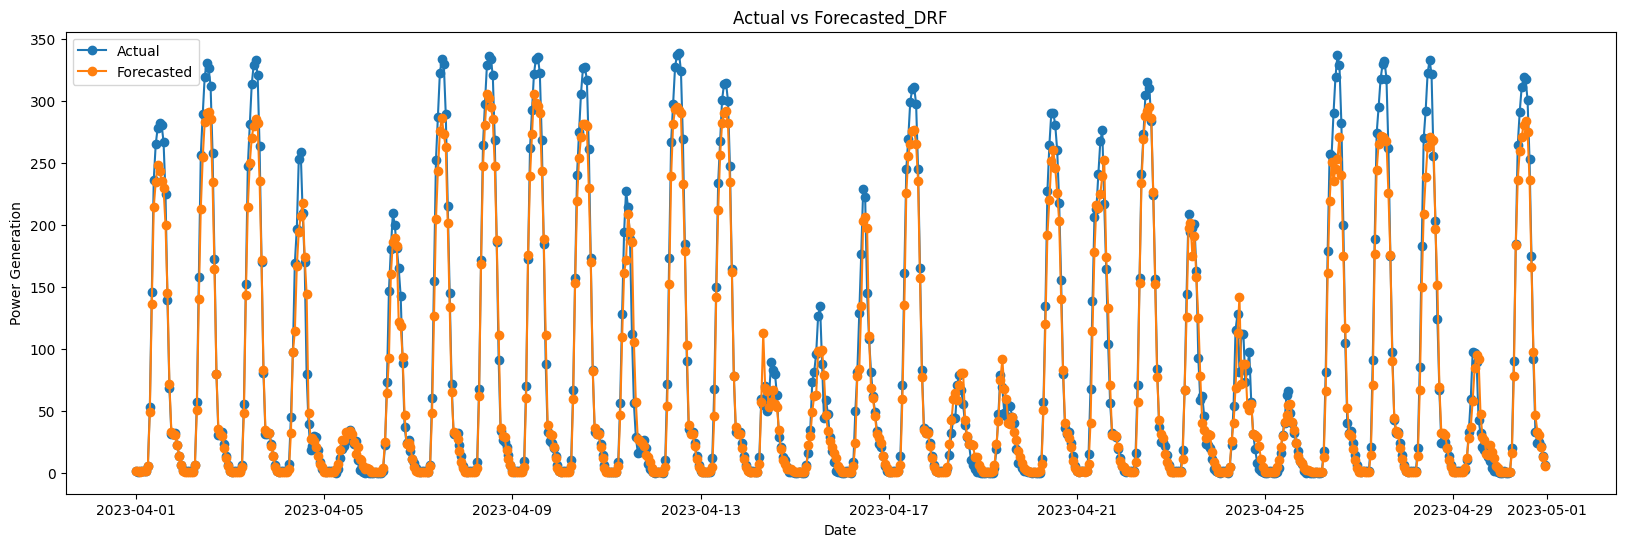

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 323.2843355498433
평균 절대 오차 (MAE): 12.332268147656565
결정 계수 (R2): 0.9711600781599323
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 17.980109442098602


<ipython-input-13-b056e2400552>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


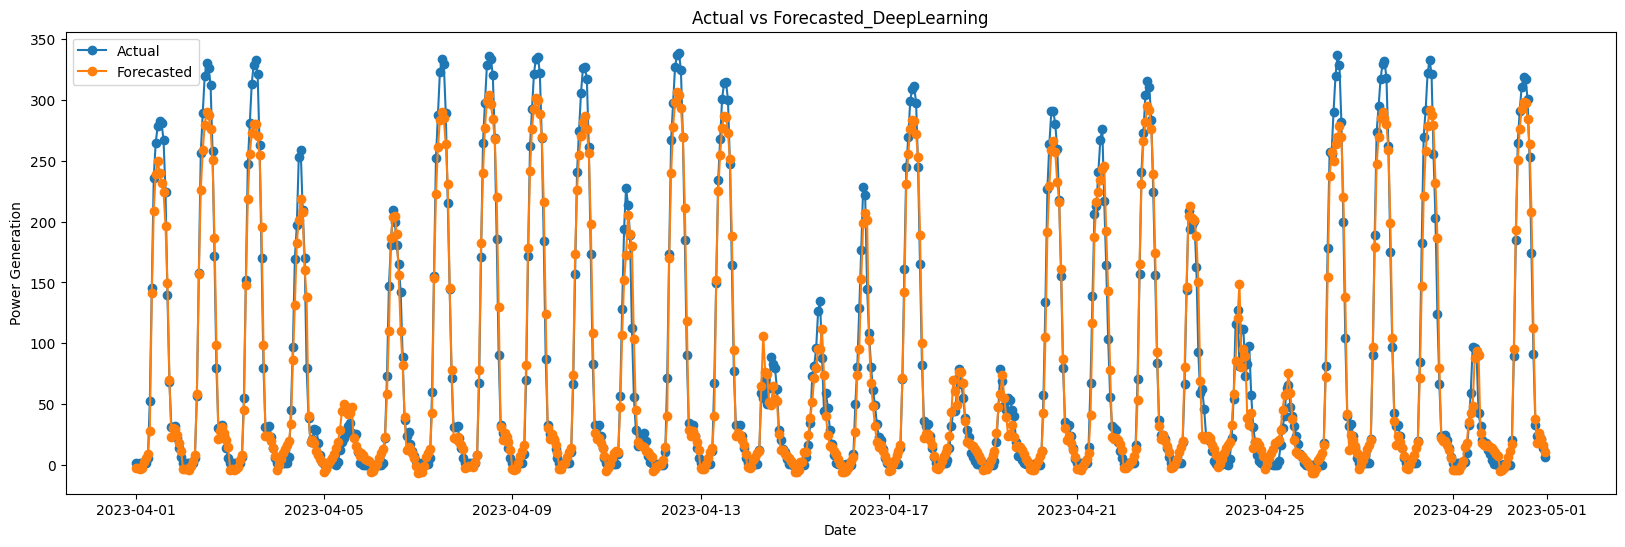

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 1549.9311897769765
평균 절대 오차 (MAE): 30.65843415721594
결정 계수 (R2): 0.8617319509322177
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 39.369165469653744


<ipython-input-13-b056e2400552>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


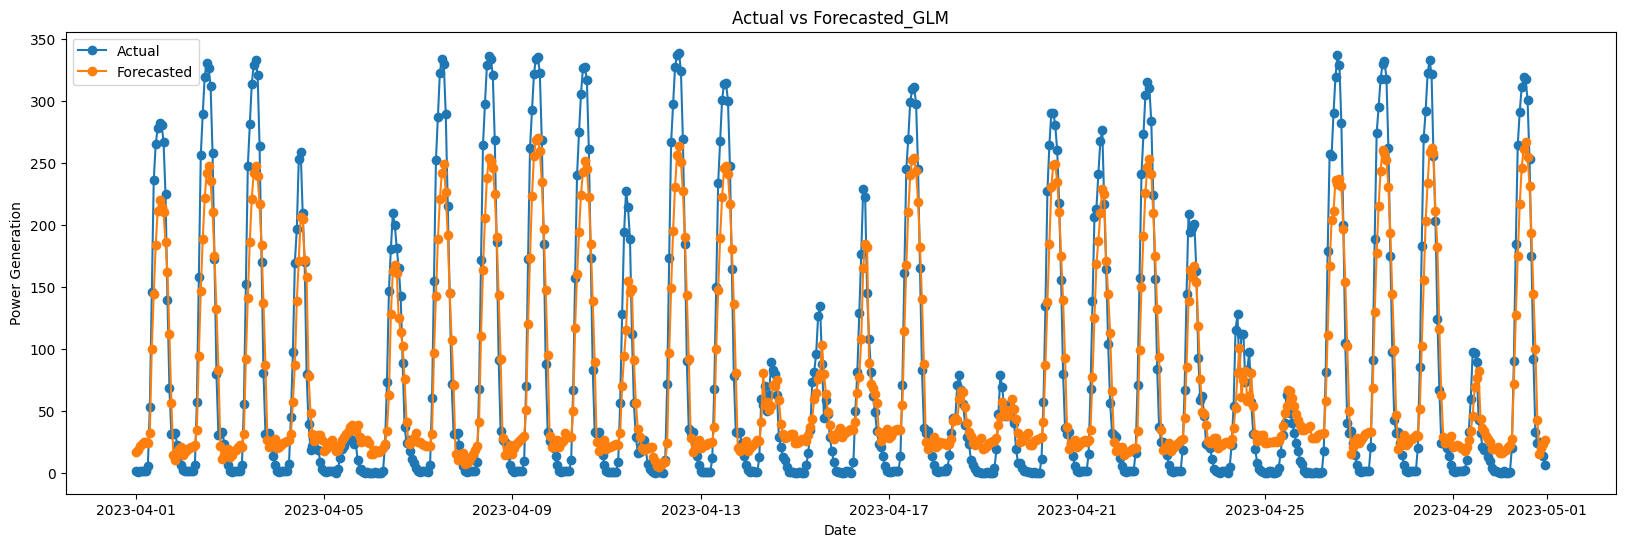

In [ ]:
all_predictions = pd.DataFrame()
all_evaluations = pd.DataFrame()
for i in [model_rank_1, model_rank_6, model_rank_16, model_rank_33, model_rank_35,model_rank_62, model_rank_73]:
  # 원하는 rank의 모델을 사용하여 예측 수행
  predictions = i.predict(h2o_test) #model_rank_n
  predictions = predictions.as_data_frame()

  # 예측된 값을 원래 스케일로 역변환
  predictions = target_scaler.inverse_transform(predictions)

  # 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
  actual_values = test['solarpower'].values.reshape(-1, 1)
  actual_values = target_scaler.inverse_transform(actual_values)

  # 각 rank의 값의 모델명을 파일명으로 사용
  name_index = i.model_id.find("_")
  model_name = i.model_id[:name_index]

  # 평가 지표 계산
  mse = mean_squared_error(actual_values, predictions)
  mae = mean_absolute_error(actual_values, predictions)
  r2 = r2_score(actual_values, predictions)
  mape = mean_absolute_percentage_error(actual_values, predictions)
  rmse = np.sqrt(mse)

  # 평가 지표 출력
  print("평균 제곱 오차 (MSE):", mse)
  print("평균 절대 오차 (MAE):", mae)
  print("결정 계수 (R2):", r2)
  print("평균 절대 백분율 오차 (MAPE):", mape)
  print("평균 제곱근 오차 (RMSE):", rmse)

  # 실제 값과 예측값 시각화
  plt.figure(figsize=(20, 6))
  plt.plot(test['Date']
           , actual_values, label='Actual', marker='o')
  plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
  plt.xlabel('Date')
  plt.ylabel('Power Generation')
  plt.title(f'Actual vs Forecasted_{model_name}')
  plt.legend()
  plt.show()

  # 모든 평가지표를 데이터프레임으로 저장
  all_evaluations[model_name] = [mse, mae, r2, mape, rmse]

  # 모든 예측값 저장
  all_predictions[model_name] = predictions[:0]


# 엑셀 파일로 저장
all_evaluations.to_excel('evaluations_온실.xlsx', index=False)

# 예측값 파일 저장
file_name = 'h20_온실.xlsx'
all_predictions.to_excel(file_name, index=False)